In [177]:
import pandas as pd
import numpy as np
#import geopandas as gpd
import matplotlib.pyplot as plt
import pdb
import os
import sqlalchemy
from matplotlib import collections  as mc
from sklearn.cluster import *
from sklearn.neighbors import *
import scipy.stats as stats
import tensorly as tl

Using mxnet backend.


In [114]:
%matplotlib inline
np.seterr(divide='raise',invalid='ignore')

{'divide': 'raise', 'invalid': 'raise', 'over': 'ignore', 'under': 'ignore'}

Data downloaded from:

https://sites.google.com/site/yangdingqi/home/foursquare-dataset

In [2]:
nyc = pd.read_table("dataset_tsmc2014/dataset_TSMC2014_NYC.txt", header=None, parse_dates=[7])
tokyo = pd.read_table("dataset_tsmc2014/dataset_TSMC2014_TKY.txt", header=None, parse_dates=[7])

In [3]:
cols = ['userid', 'venusid', 'venus_category', 'venus_category_name', 'lat', 'lon', 'tzoffset_min', 'utc']
nyc.columns = cols
tokyo.columns = cols

In [63]:
def prepare_data(dat):
    dat['local_time'] = dat.utc+map(lambda x: pd.Timedelta(x, 'm'), dat.tzoffset_min)
    dat['week_hour'] = dat.local_time.dt.weekday*24 + dat.local_time.dt.hour
    dat['month'] = dat.local_time.dt.month
    dat = dat.sort_values(['userid', 'local_time'])
    #dat.groupby(['userid', 'venus_category_name', 'week_hour']).count()
    return dat

In [64]:
nyc = prepare_data(nyc)
tokyo = prepare_data(tokyo)

In [73]:
x=pd.DataFrame(nyc.groupby(['month', 'venus_category_name']).count().userid)

In [92]:
x.columns=['counts']

In [116]:
countbymonth = x.reset_index().pivot_table('counts', 'month', 'venus_category_name')

In [121]:
countbymonth

venus_category_name,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Travel Lounge,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Winery,Wings Joint,Zoo
month,,,,,,,,,,,,,,,,,,,,,
1,NaN,3.0,222.0,266.0,2.0,NaN,NaN,8.0,2.0,2.0,...,5.0,NaN,61.0,25.0,5.0,7.0,14.0,4.0,1.0,15.0
2,NaN,2.0,92.0,136.0,2.0,3.0,NaN,9.0,NaN,1.0,...,1.0,NaN,55.0,7.0,3.0,3.0,9.0,1.0,3.0,8.0
4,2.0,15.0,417.0,701.0,25.0,4.0,2.0,78.0,2.0,1.0,...,1.0,3.0,255.0,98.0,15.0,9.0,36.0,5.0,33.0,18.0
5,NaN,8.0,593.0,658.0,13.0,5.0,3.0,84.0,5.0,6.0,...,2.0,6.0,220.0,56.0,15.0,5.0,28.0,3.0,32.0,19.0
6,NaN,4.0,388.0,396.0,2.0,5.0,NaN,58.0,5.0,1.0,...,2.0,2.0,87.0,36.0,11.0,6.0,20.0,8.0,19.0,5.0
7,1.0,3.0,329.0,444.0,6.0,NaN,2.0,54.0,NaN,3.0,...,1.0,2.0,75.0,47.0,7.0,4.0,19.0,3.0,20.0,8.0
8,NaN,3.0,125.0,196.0,1.0,NaN,3.0,19.0,1.0,2.0,...,6.0,NaN,29.0,19.0,11.0,1.0,13.0,NaN,5.0,5.0
9,1.0,NaN,46.0,93.0,NaN,1.0,1.0,7.0,NaN,1.0,...,2.0,NaN,32.0,4.0,4.0,1.0,4.0,1.0,5.0,2.0
10,NaN,1.0,151.0,195.0,3.0,4.0,NaN,24.0,2.0,3.0,...,4.0,1.0,86.0,12.0,14.0,2.0,8.0,4.0,4.0,6.0


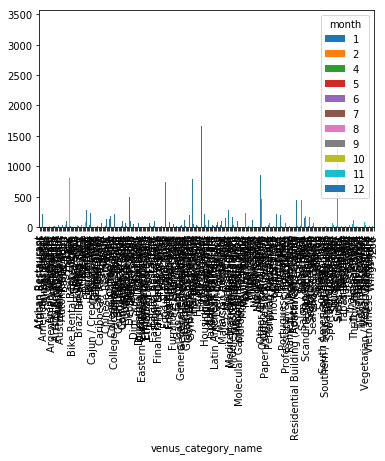

In [148]:
countbymonth.T.plot(kind='bar')

In [129]:
freqbymonth = (countbymonth.T/countbymonth.sum(axis=1)).T

In [130]:
freqbymonth.fillna(1e-6, inplace=True)

In [141]:
kldiv = np.zeros((12, 12))
# calculate pairwise kl divergence
for i in range(freqbymonth.shape[0]):
    for j in range(i, freqbymonth.shape[0]):
        kldiv[freqbymonth.index[i]-1][freqbymonth.index[j]-1] = stats.entropy(freqbymonth.iloc[i], freqbymonth.iloc[j])
        kldiv[freqbymonth.index[j]-1][freqbymonth.index[i]-1] = stats.entropy(freqbymonth.iloc[j], freqbymonth.iloc[i])

In [142]:
kldiv = pd.DataFrame(kldiv)

In [145]:
kldiv.columns = range(1, 13)
kldiv.index = range(1, 13)

In [146]:
kldiv

,1,2,3,4,5,6,7,8,9,10,11,12
1,0.000000,0.057893,0.0,0.105603,0.075145,0.059736,0.058244,0.092779,0.109873,0.060703,0.057369,0.045488
2,0.048228,0.000000,0.0,0.119523,0.087146,0.087731,0.090155,0.129596,0.120697,0.083761,0.072976,0.074181
3,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.081071,0.112390,0.0,0.000000,0.017436,0.032428,0.039980,0.071690,0.097492,0.060185,0.062764,0.074254
5,0.074581,0.115124,0.0,0.025821,0.000000,0.018052,0.027095,0.060214,0.086581,0.060860,0.064242,0.074610
6,0.067970,0.113433,0.0,0.052306,0.018580,0.000000,0.021428,0.053348,0.086203,0.065036,0.068031,0.078008
7,0.066580,0.116940,0.0,0.059313,0.027507,0.018248,0.000000,0.037108,0.073237,0.069814,0.065948,0.075730
8,0.085201,0.131932,0.0,0.082786,0.052136,0.042438,0.033658,0.000000,0.077585,0.074459,0.069165,0.083989
9,0.096775,0.141832,0.0,0.081048,0.064198,0.061801,0.058384,0.086832,0.000000,0.082911,0.082100,0.096715
10,0.065662,0.115946,0.0,0.078104,0.062343,0.060495,0.074773,0.090732,0.102303,0.000000,0.034463,0.063657


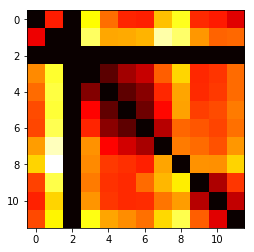

In [149]:
plt.imshow(kldiv, cmap='hot', interpolation='nearest')

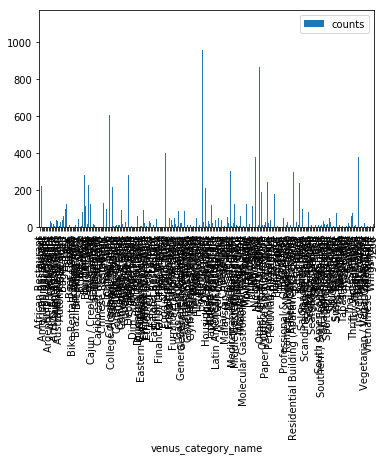

In [97]:
x.loc[1].plot(kind='bar')

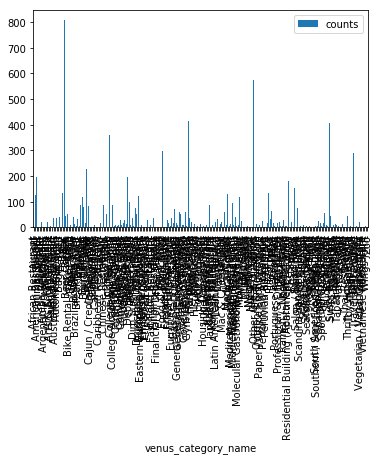

In [98]:
x.loc[8].plot(kind='bar')

In [99]:
x.to_clipboard()

/usr/local/lib/python2.7/dist-packages/pandas/util/clipboard.py:137: GtkWarning: Error converting from UTF-8 to ASCII: Invalid byte sequence in conversion input
  cb.store()


In [107]:
pd.DataFrame(x.groupby(level=0, as_index=False).apply(lambda x: x['counts']/x.counts.sum())).to_clipboard()

In [171]:
uservenushour_tenor = nyc.groupby(['userid', 'venus_category_name', 'week_hour']).count()['utc']
uservenushour_tenor.name = 'count'

In [172]:
uservenushour_tenor = pd.DataFrame(uservenushour_tenor).unstack().fillna(0).unstack().fillna(0)

In [178]:
uservenushour_tenor

count                             \
week_hour                         0                                
venus_category_name Afghan Restaurant African Restaurant Airport   
userid                                                             
1                                 0.0                0.0     0.0   
2                                 0.0                0.0     0.0   
3                                 0.0                0.0     0.0   
4                                 0.0                0.0     0.0   
5                                 0.0                0.0     0.0   
6                                 0.0                0.0     0.0   
7                                 0.0                0.0     0.0   
8                                 0.0                0.0     0.0   
9                                 0.0                0.0     0.0   
10                                0.0                0.0     0.0   
11                                0.0                0.0     0.0   
12                                0.0                0.0     0.0   
13                                0.0                0.0     0.0   
14                                0.0                0.0     0.0   
15                                0.0                0.0     0.0   
16                                0.0                0.0     0.0   
17                                0.0                0.0     0.0   
18                                0.0                0.0     0.0   
19                                0.0                0.0     0.0   
20                                0.0                0.0     0.0   
21                                0.0                0.0     0.0   
22                                0.0                0.0     0.0   
23                                0.0                0.0     0.0   
24                                0.0                0.0     0.0   
25                                0.0                0.0     0.0   
26                                0.0                0.0     0.0   
27                                0.0                0.0     0.0   
28                                0.0                0.0     0.0   
29                                0.0                0.0     0.0   
30                                0.0                0.0     0.0   
...                               ...                ...     ...   
1054                              0.0                0.0     0.0   
1055                              0.0                0.0     0.0   
1056                              0.0                0.0     0.0   
1057                              0.0                0.0     0.0   
1058                              0.0                0.0     0.0   
1059                              0.0                0.0     0.0   
1060                              0.0                0.0     0.0   
1061                              0.0                0.0     0.0   
1062                              0.0                0.0     0.0   
1063                              0.0                0.0     0.0   
1064                              0.0                0.0     0.0   
1065                              0.0                0.0     0.0   
1066                              0.0                0.0     0.0   
1067                              0.0                0.0     0.0   
1068                              0.0                0.0     0.0   
1069                              0.0                0.0     0.0   
1070                              0.0                0.0     0.0   
1071                              0.0                0.0     0.0   
1072                              0.0                0.0     0.0   
1073                              0.0                0.0     0.0   
1074                              0.0                0.0     0.0   
1075                              0.0                0.0     0.0   
1076                              0.0                0.0     0.0   
1077                              0.0                0.0     0.0   
1078                

In [180]:
# reshape into tenor of user x hour x tenus
uvh = uservenushour_tenor.values.reshape((uservenushour_tenor.shape[0], 168, uservenushour_tenor.shape[1]/168))

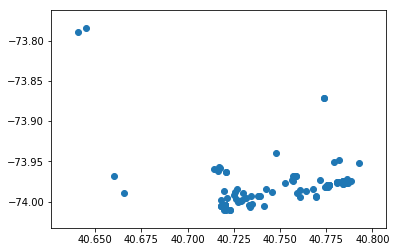

In [29]:
x=nyc[nyc.userid==1]
plt.scatter(x.lat, x.lon)

In [43]:
model = DBSCAN(eps=0.05)

In [44]:
model.fit_predict(x[['lat', 'lon']])

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1, -1,  0,
        0,  0,  0, -1])

In [39]:
model.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1, -1,  0,
        0,  0,  0, -1])

In [49]:
pd.merge(x, pd.DataFrame((x.groupby('venus_category_name').count()/x.shape[0]).iloc[:, 0]), right_index=True, left_on='venus_category_name')

,userid_x,venusid,venus_category,venus_category_name,lat,lon,tzoffset_min,utc,local_time,userid_y
2454,1,4abc1f51f964a520798620e3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.781558,-73.975792,-240,2012-04-04 23:31:31,2012-04-04 19:31:31,0.094340
40028,1,4abc1f51f964a520798620e3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.781558,-73.975792,-240,2012-04-28 01:13:47,2012-04-27 21:13:47,0.094340
87065,1,4a9f1cedf964a520903c20e3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.788637,-73.974225,-240,2012-05-28 21:20:22,2012-05-28 17:20:22,0.094340
104169,1,4e186a7062e12640d874ee41,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.720537,-73.963521,-240,2012-06-10 17:38:50,2012-06-10 13:38:50,0.094340
104610,1,4581734ff964a520653f1fe3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.717759,-73.958584,-240,2012-06-10 22:02:57,2012-06-10 18:02:57,0.094340
110578,1,4cc9a5760f7bef3b5f9c7fdd,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.745889,-73.988521,-240,2012-06-16 21:29:30,2012-06-16 17:29:30,0.094340
110796,1,3fd66200f964a52074e71ee3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.752505,-73.977580,-240,2012-06-16 23:33:50,2012-06-16 19:33:50,0.094340
120114,1,422b9980f964a520cd1f1fe3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.738445,-73.993564,-240,2012-07-03 21:12:56,2012-07-03 17:12:56,0.094340
133895,1,4d06fb7d2f96f04d25af2a54,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.784250,-73.977760,-240,2012-07-15 17:33:29,2012-07-15 13:33:29,0.094340
195850,1,3fd66200f964a52048e31ee3,4bf58dd8d48988d1ce941735,Seafood Restaurant,40.734895,-74.003155,-300,2012-12-14 17:55:32,2012-12-14 12:55:32,0.094340
